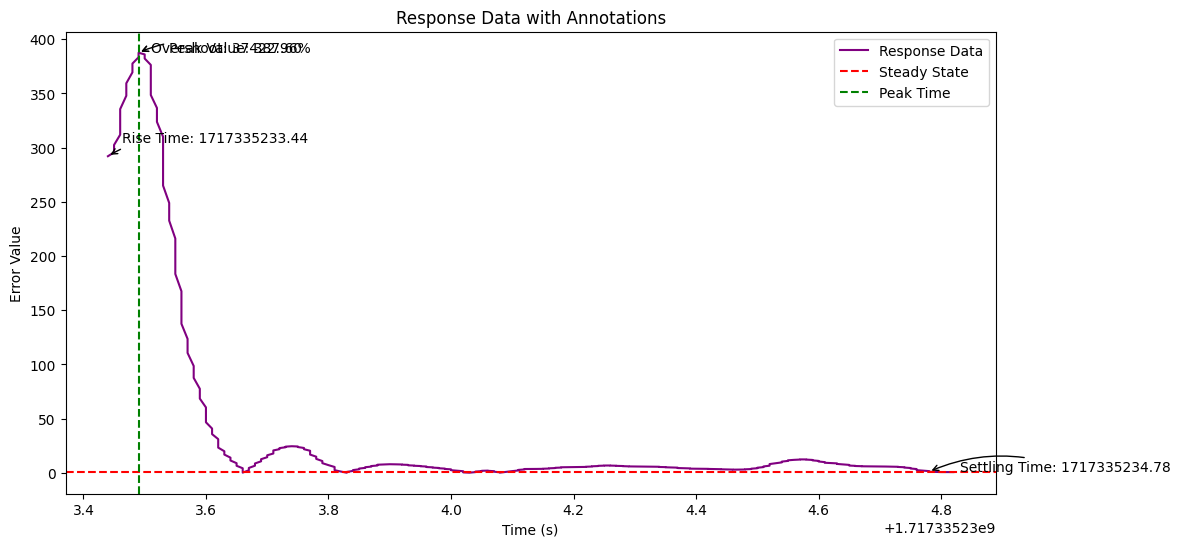

Steady State Value: 1.03
Peak Time: 1717335233.49
Peak Value: 387.60
Overshoot (%): 37422.96
Rise Time: 1717335233.44
Settling Time: 1717335234.78
Undershoot (%): None


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

# Memuat data dari file CSV
data = pd.read_csv('robot_data.csv')

# Menerapkan filter Gaussian
sigma = 5  # filter Gaussian
smoothed_speed_data = gaussian_filter1d(data['error'], sigma)

# Ekstraksi waktu dan respons
time = data['time'].values
response = smoothed_speed_data

def annotate_plot(ax, time, data, text):
    for t, d in zip(time, data):
        ax.annotate(text, xy=(t, d), xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

def plot_data_with_annotations(time, response):
    global steady_state_value, peak_time, peak_value, overshoot, rise_time, settling_time, undershoot
    response = np.abs(response)

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(time, response, label='Response Data', color='purple')

    # Nilai steady state
    steady_state_value = np.mean(response[-10:])
    ax.axhline(y=steady_state_value, color='r', linestyle='--', label='Steady State')

    # Waktu dan nilai puncak
    peaks, _ = find_peaks(response)
    peak_time = time[peaks][0] if peaks.size > 0 else None
    if peak_time is not None:
        ax.axvline(x=peak_time, color='g', linestyle='--', label='Peak Time')

    if peak_time is not None:
        peak_value = response[peaks][0]
        peakValue_text = f'Peak Value: {peak_value:.2f}'
        ax.annotate(peakValue_text, xy=(peak_time, peak_value), xytext=(peak_time + 0.05, peak_value - 0.02),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    # Rise time
    rise_time_index = np.where(response >= 0.9 * steady_state_value)[0][0] if np.any(response >= 0.9 * steady_state_value) else None
    if rise_time_index is not None:
        rise_time = time[rise_time_index]
        annotate_plot(ax, [rise_time], [response[rise_time_index]], f'Rise Time: {rise_time:.2f}')

    # Settling time
    settling_index = np.where(np.abs(response - steady_state_value) <= 0.02 * steady_state_value)[0]
    settling_time = time[settling_index[0]] if settling_index.size > 0 else None
    if settling_time:
        settlingTime_text = f'Settling Time: {settling_time:.2f}'
        ax.annotate(settlingTime_text, xy=(settling_time, response[settling_index[0]]), xytext=(settling_time + 0.05, response[settling_index[0]] - 0.002),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    # Overshoot
    overshoot = ((peak_value - steady_state_value) / steady_state_value) * 100 if peak_value is not None else None
    if overshoot is not None:
        overshoot_text = f'Overshoot: {overshoot:.2f}%'
        ax.annotate(overshoot_text, xy=(peak_time, peak_value), xytext=(peak_time + 0.02, peak_value - 0.0258),
                    textcoords='data', arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

    # Undershoot
    undershoot = None
    if np.any(response < 0):
        undershoot_value = np.min(response)
        undershoot = ((steady_state_value - undershoot_value) / steady_state_value) * 100 if undershoot_value is not None else None
    if undershoot is not None:
        annotate_plot(ax, [peak_time], [peak_value], f'Undershoot: {undershoot:.2f}%')

    ax.legend()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Error Value')
    ax.set_title('Response Data with Annotations')
    ax.grid(False)

    # Membalik sumbu y jika ada nilai negatif
    if np.any(response < 0):
        ax.set_ylim(ax.get_ylim()[::-1])

    plt.show()
    return {
        'Steady State Value': steady_state_value,
        'Peak Time': peak_time,
        'Peak Value': peak_value,
        'Overshoot (%)': overshoot,
        'Rise Time': rise_time,
        'Settling Time': settling_time,
        'Undershoot (%)': undershoot
    }

# Jalankan fungsi plot dan cetak metrik
metrics = plot_data_with_annotations(time, response)
if metrics:
    for metric, value in metrics.items():
        if value is not None:
            print(f"{metric}: {value:.2f}")
        else:
            print(f"{metric}: None")


Steady State: -3.9607999999999994
Peak Time: 214
Peak Value: 33.84
Overshoot: -954.3728539688952%
Rise Time: -67
Settling Time: 0


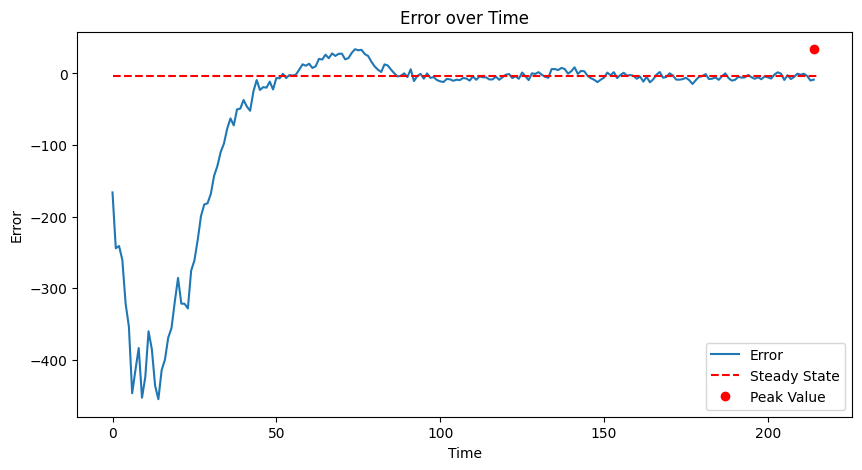

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Membaca data dari file CSV
data = pd.read_csv('robot_data.csv')

# Menghitung steady state
# Steady state biasanya dihitung sebagai nilai rata-rata dari error setelah sistem stabil
steady_state = data['error'][data.index[-100:]].mean()

# Menghitung peak time dan peak value
# Peak time adalah waktu dimana output mencapai nilai maksimum pertama kali
# Peak value adalah nilai maksimum dari output
peak_value = data['error'].max()
peak_time = data['time'].idxmax()

# Menghitung overshoot
# Overshoot adalah persentase dimana output melebihi steady state
overshoot = ((peak_value - steady_state) / steady_state) * 100

# Menghitung rise time
# Rise time adalah waktu yang dibutuhkan untuk error naik dari 10% ke 90% dari peak value
rise_time_start = data['error'].sub(peak_value * 0.1).abs().idxmin()
rise_time_end = data['error'].sub(peak_value * 0.9).abs().idxmin()
rise_time = rise_time_end - rise_time_start

# Menghitung settling time
# Settling time adalah waktu yang dibutuhkan untuk error berada dalam range tertentu dari steady state
settling_time_threshold = steady_state * 0.05
settling_time = data['error'].sub(steady_state).abs().le(settling_time_threshold).idxmax()

# Menampilkan hasil perhitungan
print(f'Steady State: {steady_state}')
print(f'Peak Time: {peak_time}')
print(f'Peak Value: {peak_value}')
print(f'Overshoot: {overshoot}%')
print(f'Rise Time: {rise_time}')
print(f'Settling Time: {settling_time}')

# Membuat plot untuk error
plt.figure(figsize=(10, 5))
plt.plot(data['error'], label='Error')
plt.plot([0, len(data['error'])], [steady_state, steady_state], 'r--', label='Steady State')
plt.plot(peak_time, peak_value, 'ro', label='Peak Value')
plt.legend()
plt.title('Error over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()


Steady State: 0
Peak Time: 4.8
Peak Value: 33.84
Overshoot: -492.1205098493627%
Rise Time: 3.71
Settling Time: nan


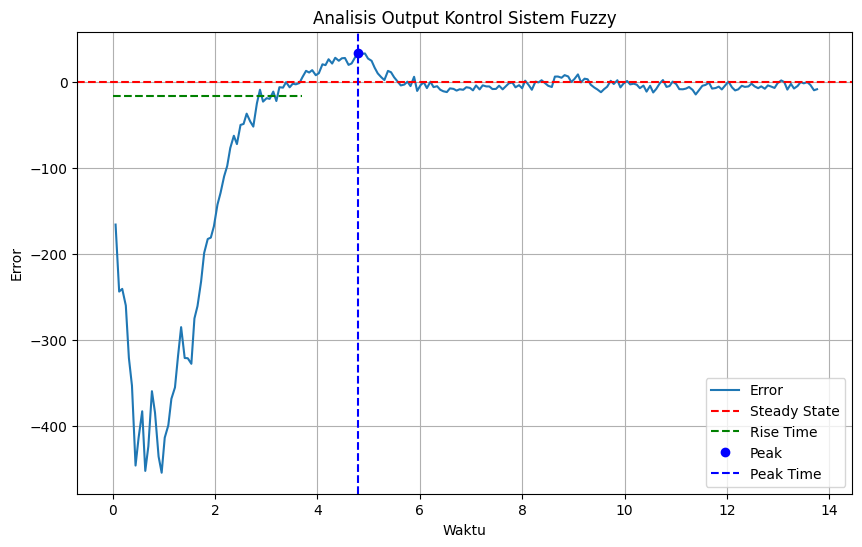

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Membaca data dari file CSV
data = pd.read_csv('robot_data.csv')

# Mengambil kolom 'error' dan 'time'
error = data['error']
time = data['time']

# Steady state error
steady_state_error = 0

# Peak value dan peak time
peak_indices, _ = find_peaks(error)
if len(peak_indices) > 0:
    peak_value = error[peak_indices].max()
    peak_index = error[peak_indices].idxmax()
    peak_time = time[peak_index]
else:
    peak_value = np.nan
    peak_time = np.nan

# Overshoot
final_on_error_value = error.iloc[-1] if error.iloc[-1] != 0 else error[error.index[-2]]  # Ambil nilai error terakhir atau nilai error kedua terakhir jika terakhir adalah 0
if final_on_error_value != 0:
    overshoot = ((peak_value - final_on_error_value) / final_on_error_value) * 100
else:
    overshoot = np.nan

# Rise time (waktu untuk error mencapai steady state (0) pertama kali)
try:
    zero_crossings = np.where(np.diff(np.sign(error - steady_state_error)))[0]
    rise_time_index = zero_crossings[0] + 1
    rise_time = time[rise_time_index]
except IndexError:
    rise_time = np.nan

# Settling time (waktu untuk error tetap berada dalam 2% dari steady state error)
settling_threshold = 0.02 * steady_state_error
try:
    within_settling_threshold = np.abs(error - steady_state_error) <= settling_threshold
    settling_time = time[within_settling_threshold].iloc[-1]
except IndexError:
    settling_time = np.nan

# Menampilkan hasil
print(f"Steady State: {steady_state_error}")
print(f"Peak Time: {peak_time}")
print(f"Peak Value: {peak_value}")
print(f"Overshoot: {overshoot}%")
print(f"Rise Time: {rise_time}")
print(f"Settling Time: {settling_time}")

# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(time, error, label='Error')
plt.axhline(y=steady_state_error, color='r', linestyle='--', label='Steady State')

if not np.isnan(rise_time):
    plt.hlines(y=steady_state_error - 0.5 * abs(peak_value), xmin=0, xmax=rise_time, colors='g', linestyles='--', label='Rise Time')

if not np.isnan(peak_time):
    plt.plot(peak_time, peak_value, 'bo', label='Peak')
    plt.axvline(x=peak_time, color='b', linestyle='--', label='Peak Time')

if not np.isnan(settling_time):
    plt.axvline(x=settling_time, color='m', linestyle='--', label='Settling Time')

plt.xlabel('Waktu')
plt.ylabel('Error')
plt.title('Analisis Output Kontrol Sistem Fuzzy')
plt.legend()
plt.grid(True)
plt.show()
